# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=10,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-02-37/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5078 | MulticlassF1Score=0.0973
Batch-30 : CrossEntropyLoss=2.4887 | MulticlassF1Score=0.1830
Batch-45 : CrossEntropyLoss=2.3982 | MulticlassF1Score=0.3012
Batch-60 : CrossEntropyLoss=2.3622 | MulticlassF1Score=0.3833
Batch-75 : CrossEntropyLoss=2.3623 | MulticlassF1Score=0.4369
Batch-90 : CrossEntropyLoss=2.3598 | MulticlassF1Score=0.4728
Batch-105: CrossEntropyLoss=2.3393 | MulticlassF1Score=0.4998
Batch-120: CrossEntropyLoss=2.3431 | MulticlassF1Score=0.5211
Batch-135: CrossEntropyLoss=2.3393 | MulticlassF1Score=0.5385
Batch-150: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.5510
Batch-165: CrossEntropyLoss=2.3478 | MulticlassF1Score=0.5620
Batch-180: CrossEntropyLoss=2.3312 | MulticlassF1Score=0.5749
Batch-195: CrossEntropyLoss=2.3371 | MulticlassF1Score=0.5859
Batch-210: CrossEntropyLoss=2.3280 | MulticlassF1Score=0.5965
Batch-225: CrossEntropyLoss=2.3388 | MulticlassF1Score=0.6064
Batch-226: CrossEntropyLoss=2.3469 | MulticlassF1Score=0.6067

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3321 | MulticlassF1Score=0.7455
Batch-30 : CrossEntropyLoss=2.3180 | MulticlassF1Score=0.7401
Batch-45 : CrossEntropyLoss=2.3313 | MulticlassF1Score=0.7377
Batch-60 : CrossEntropyLoss=2.3463 | MulticlassF1Score=0.7382
Batch-63 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7389

Training   : Mean CrossEntropyLoss = 2.3827 | Mean MulticlassF1Score = 0.4453
Validation : Mean CrossEntropyLoss = 2.3296 | Mean MulticlassF1Score = 0.7405

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3263 | MulticlassF1Score=0.7482
Batch-30 : CrossEntropyLoss=2.3336 | MulticlassF1Score=0.7447
Batch-45 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7484
Batch-60 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7573
Batch-75 : CrossEntropyLoss=2.3239 | MulticlassF1Score=0.7635
Batch-90 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7679
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7726
Batch-120: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7746
Batch-135: CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7769
Batch-150: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7793
Batch-165: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7811
Batch-180: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7823
Batch-195: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7835
Batch-210: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7849
Batch-225: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7862
Batch-226: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7863

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7971
Batch-30 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7984
Batch-45 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7991
Batch-60 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7990
Batch-63 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.7995

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3150 | Mean MulticlassF1Score = 0.7694
Validation : Mean CrossEntropyLoss = 2.3105 | Mean MulticlassF1Score = 0.7982

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7942
Batch-30 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7968
Batch-45 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8010
Batch-60 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.8007
Batch-75 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8002
Batch-90 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8002
Batch-105: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8004
Batch-120: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8009
Batch-135: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8021
Batch-150: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8032
Batch-165: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8037
Batch-180: CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8036
Batch-195: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8040
Batch-210: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8041
Batch-225: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8038
Batch-226: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8038

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8046
Batch-30 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8050
Batch-45 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8030
Batch-60 : CrossEntropyLoss=2.3236 | MulticlassF1Score=0.8024
Batch-63 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8025

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3088 | Mean MulticlassF1Score = 0.8009
Validation : Mean CrossEntropyLoss = 2.3091 | Mean MulticlassF1Score = 0.8033

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.8127
Batch-30 : CrossEntropyLoss=2.3267 | MulticlassF1Score=0.8061
Batch-45 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8055
Batch-60 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8068
Batch-75 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8076
Batch-90 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8080
Batch-105: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8084
Batch-120: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8091
Batch-135: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8091
Batch-150: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8104
Batch-165: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8124
Batch-180: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8134
Batch-195: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8141
Batch-210: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8147
Batch-225: CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8152
Batch-226: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8153

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8225
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8247
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8239
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8237
Batch-63 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8241

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3050 | Mean MulticlassF1Score = 0.8102
Validation : Mean CrossEntropyLoss = 2.3024 | Mean MulticlassF1Score = 0.8237

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8284
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8318
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8320
Batch-60 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8304
Batch-75 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8303
Batch-90 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8301
Batch-105: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8304
Batch-120: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8306
Batch-135: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8316
Batch-150: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8326
Batch-165: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8328
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8328
Batch-195: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8330
Batch-210: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8336
Batch-225: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8335
Batch-226: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8334

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8353
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8348
Batch-45 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8337
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8327
Batch-63 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8322

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2993 | Mean MulticlassF1Score = 0.8316
Validation : Mean CrossEntropyLoss = 2.2998 | Mean MulticlassF1Score = 0.8351

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8381
Batch-30 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8415
Batch-45 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8407
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8401
Batch-75 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8403
Batch-90 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8406
Batch-105: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8425
Batch-120: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8434
Batch-135: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8451
Batch-150: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8455
Batch-165: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8461
Batch-180: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8469
Batch-195: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8475
Batch-210: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8478
Batch-225: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8481
Batch-226: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8450
Batch-30 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8457
Batch-45 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8483
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8494
Batch-63 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8488

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2949 | Mean MulticlassF1Score = 0.8431
Validation : Mean CrossEntropyLoss = 2.2949 | Mean MulticlassF1Score = 0.8465

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8507
Batch-30 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8547
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8551
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8563
Batch-75 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8566
Batch-90 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8571
Batch-105: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8565
Batch-120: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8567
Batch-135: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8564
Batch-150: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8563
Batch-165: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8559
Batch-180: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8560
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8576
Batch-210: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8590
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8608
Batch-226: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8608

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8736
Batch-30 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8767
Batch-45 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8755
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8753
Batch-63 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8755

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2909 | Mean MulticlassF1Score = 0.8563
Validation : Mean CrossEntropyLoss = 2.2867 | Mean MulticlassF1Score = 0.8765

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8870
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8871
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8852
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8840
Batch-75 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8840
Batch-90 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8843
Batch-105: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8843
Batch-120: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8849
Batch-135: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8846
Batch-150: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8839
Batch-165: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8845
Batch-180: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8847
Batch-195: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8847
Batch-210: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8850
Batch-225: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8849
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8849

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8773
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8781
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8786
Batch-60 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8794
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8801

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8852
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8777

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8907
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8902
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8899
Batch-75 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8910
Batch-90 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8902
Batch-105: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8899
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8900
Batch-135: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8897
Batch-150: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8897
Batch-165: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8897
Batch-180: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8894
Batch-195: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8893
Batch-210: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8890
Batch-225: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8892
Batch-226: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8891

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8758
Batch-30 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8789
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8805
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8808
Batch-63 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8810

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8902
Validation : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8802

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8930
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8939
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8925
Batch-75 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8930
Batch-90 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8929
Batch-105: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8929
Batch-120: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8930
Batch-135: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8929
Batch-150: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8926
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8924
Batch-180: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8921
Batch-195: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8917
Batch-210: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8918
Batch-225: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8918
Batch-226: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8917

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8814
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8829
Batch-60 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8833
Batch-63 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8830

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8930
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8814

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8965
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8944
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8935
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8938
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8928
Batch-90 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8939
Batch-105: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8936
Batch-120: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8943
Batch-135: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8939
Batch-150: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8938
Batch-165: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8938
Batch-180: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8941
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8941
Batch-210: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8939
Batch-225: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8941
Batch-226: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8850
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8857
Batch-45 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8844
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8839

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8939
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8865

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8973
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8958
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8954
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8949
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8956
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8960
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8959
Batch-120: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8953
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8954
Batch-150: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8956
Batch-180: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8959
Batch-195: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8958
Batch-210: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8957
Batch-225: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8955
Batch-226: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.8955

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8842
Batch-30 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8861
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8860
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8859
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8854

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8959
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8849

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8986
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8966
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8972
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8984
Batch-90 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8976
Batch-105: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8978
Batch-120: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8982
Batch-135: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8978
Batch-150: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8976
Batch-165: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8979
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8979
Batch-195: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8978
Batch-210: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8977
Batch-225: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8977
Batch-226: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8977

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8844
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8861
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8859
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8846
Batch-63 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8848

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8978
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8859

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9015
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8994
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9008
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8991
Batch-75 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8994
Batch-90 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8996
Batch-105: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8996
Batch-120: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8993
Batch-135: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8996
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8991
Batch-165: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8990
Batch-195: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8989
Batch-210: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8990
Batch-225: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8988
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.8988

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8830
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8839
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8858
Batch-63 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8858

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8998
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8836

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8974
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9001
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8999
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9003
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9002
Batch-90 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8999
Batch-105: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8994
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8988
Batch-135: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8988
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8992
Batch-165: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8988
Batch-180: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8992
Batch-195: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8996
Batch-210: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8997
Batch-225: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8996
Batch-226: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8996

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8889
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8865
Batch-45 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8866
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8859
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8854

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.8993
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8869

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9015
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8990
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9007
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9004
Batch-75 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9015
Batch-90 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9011
Batch-105: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9022
Batch-120: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9017
Batch-135: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9016
Batch-150: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9017
Batch-165: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9014
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9011
Batch-195: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9006
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9006
Batch-225: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9007
Batch-226: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9007

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8900
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8887
Batch-45 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8891
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8874

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.9014
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8891

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9059
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9039
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9037
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9036
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9046
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9043
Batch-135: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9039
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9040
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9037
Batch-180: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9035
Batch-195: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9034
Batch-210: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9032
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9031
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9032

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8925
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8920
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8888
Batch-63 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8887

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2775 | Mean MulticlassF1Score = 0.9037
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8921

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9017
Batch-30 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9083
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9132
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9163
Batch-90 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9177
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9187
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9203
Batch-135: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9208
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9220
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9227
Batch-180: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9234
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9239
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9244
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9251
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9251

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9133
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9148
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9160
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9145
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9150

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9171
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9153

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9332
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9334
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9339
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9339
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9340
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9337
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9335
Batch-120: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9330
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9326
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9322
Batch-165: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9323
Batch-180: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9325
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9326
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9324
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9324
Batch-226: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9324

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9157
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9145
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9152

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9330
Validation : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9164

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9310
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9331
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9333
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9330
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9333
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9336
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9336
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9338
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9336
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9339
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9338
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9337
Batch-210: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9333
Batch-226: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9142
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9184
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9172
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9164

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9326
Validation : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9163

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9317
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9333
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9329
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9331
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9336
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9338
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9341
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9344
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9342
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9342
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9343
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9341
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9341

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9171
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9154
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9176
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9174

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9335
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9160

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9394
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9385
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9389
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9387
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9387
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9388
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9386
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9386

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9206
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9236

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9219

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9406
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9416
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9409
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9407
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9408
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9409
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9407
Batch-226: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9204
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9224
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9230

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9218

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9419
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9418
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9234

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9239

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9427
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9420
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9422
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9246
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9247

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9425
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9256

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9439
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9425
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9242

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9252

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9248

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9237

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9448
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9243

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9449
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9240

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9448
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9246

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9450
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9239

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9250

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9269

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9449
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9427
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9419
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9419

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9231

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9220
Patience = 1/50‚ùó

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9475
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9498
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9507
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9521
Batch-226: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9522

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9429

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2624 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9438

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9632
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9636
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9637
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9640
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9643
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9430

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9437

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9644
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9658
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9656
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9653
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9652
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9652
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9445
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9443

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9655
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9423

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9660
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9663
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9664
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9663
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9661
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9660
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9660

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9455

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9472

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9662
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9669
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9455

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9468

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9452

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9459

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9371
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9457

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9401

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9454

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9451

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9453
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9452

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9458

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9443
Batch-63 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9446

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9430
Patience = 2/50‚ùó

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9679
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9441

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9459
Patience = 3/50‚ùó

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9632
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9659
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9655
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9655

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9447

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9464
Patience = 4/50‚ùó

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9647
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9661
Batch-180: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9660
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9659
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9444
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9442

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9660
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9447

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9659
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9664
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9439

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9452

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9449

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9671
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9418

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9457

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9468

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9683
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9457

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9439

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9453

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9445

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9679
Batch-75 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9448
Batch-63 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9451

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9447
Patience = 5/50‚ùó

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2571
Best CrossEntropyLoss training    : 2.2644
Best MulticlassF1Score validation : 0.9686
Best MulticlassF1Score validation : 0.9445
Training duration                 : 2.6323 minutes.
Training date                     : 2022-10-19 13:54:18.360525+08:00


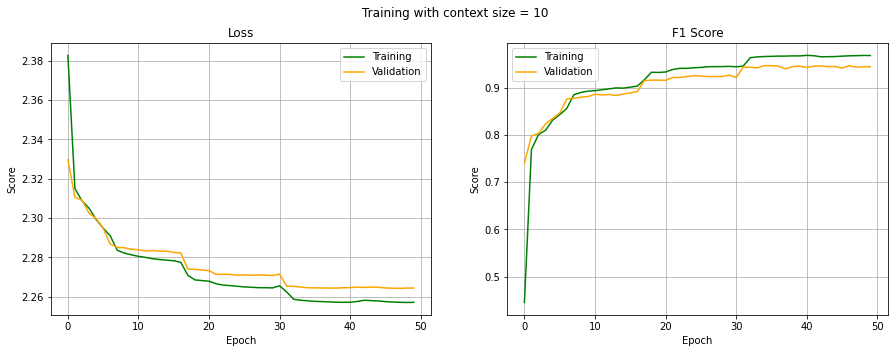

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9686, device='cuda:0'),
 tensor(0.9451, device='cuda:0'),
 tensor(0.9464, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9686, device='cuda:0'),
 tensor(0.9451, device='cuda:0'),
 tensor(0.9464, device='cuda:0'))

## Heatmap

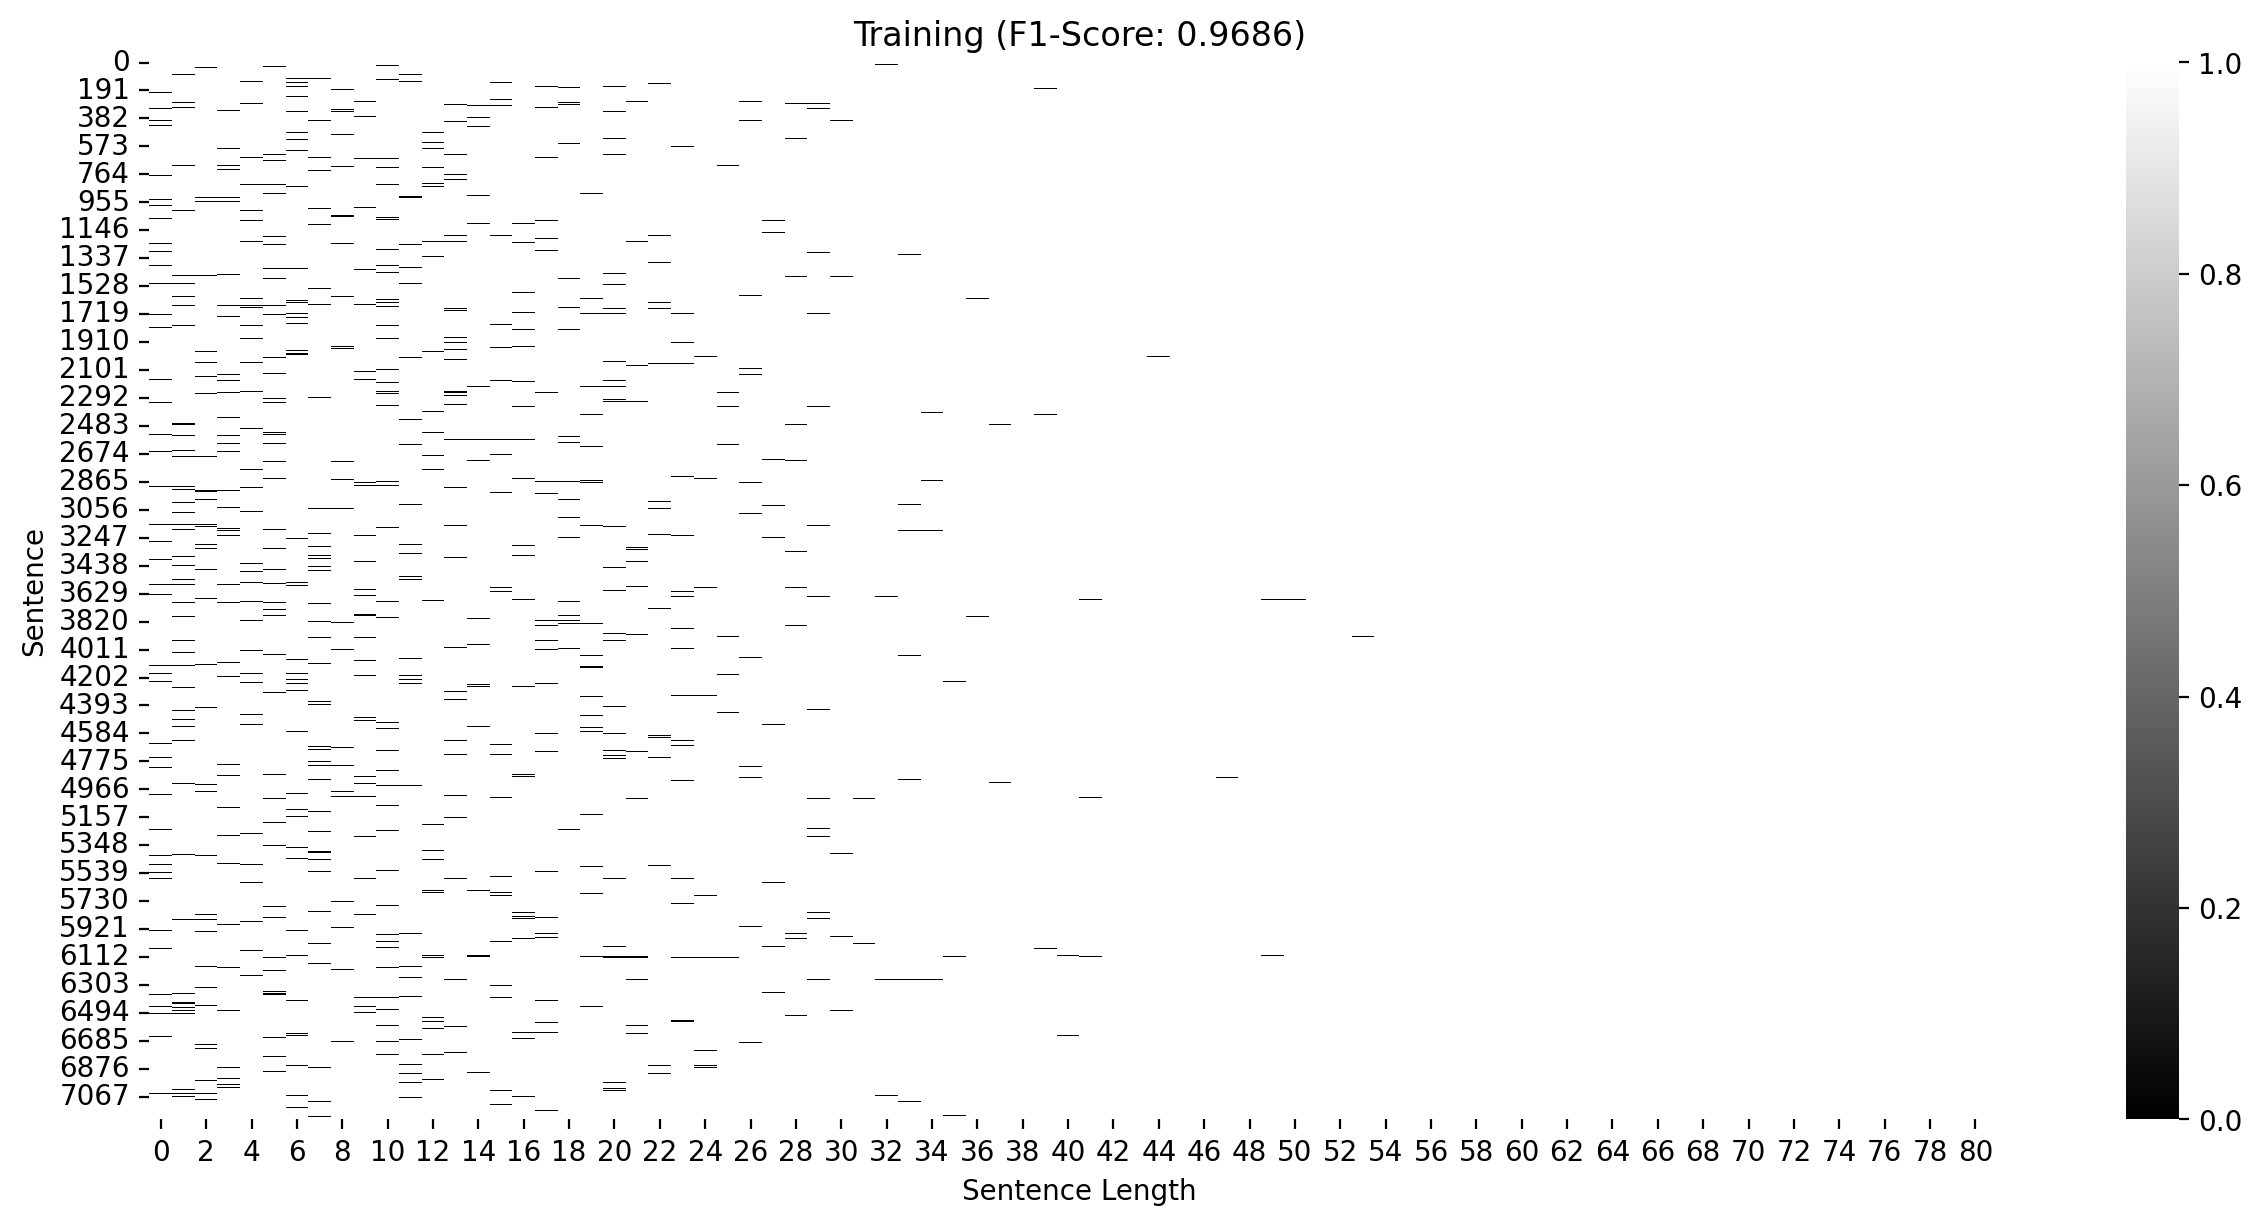

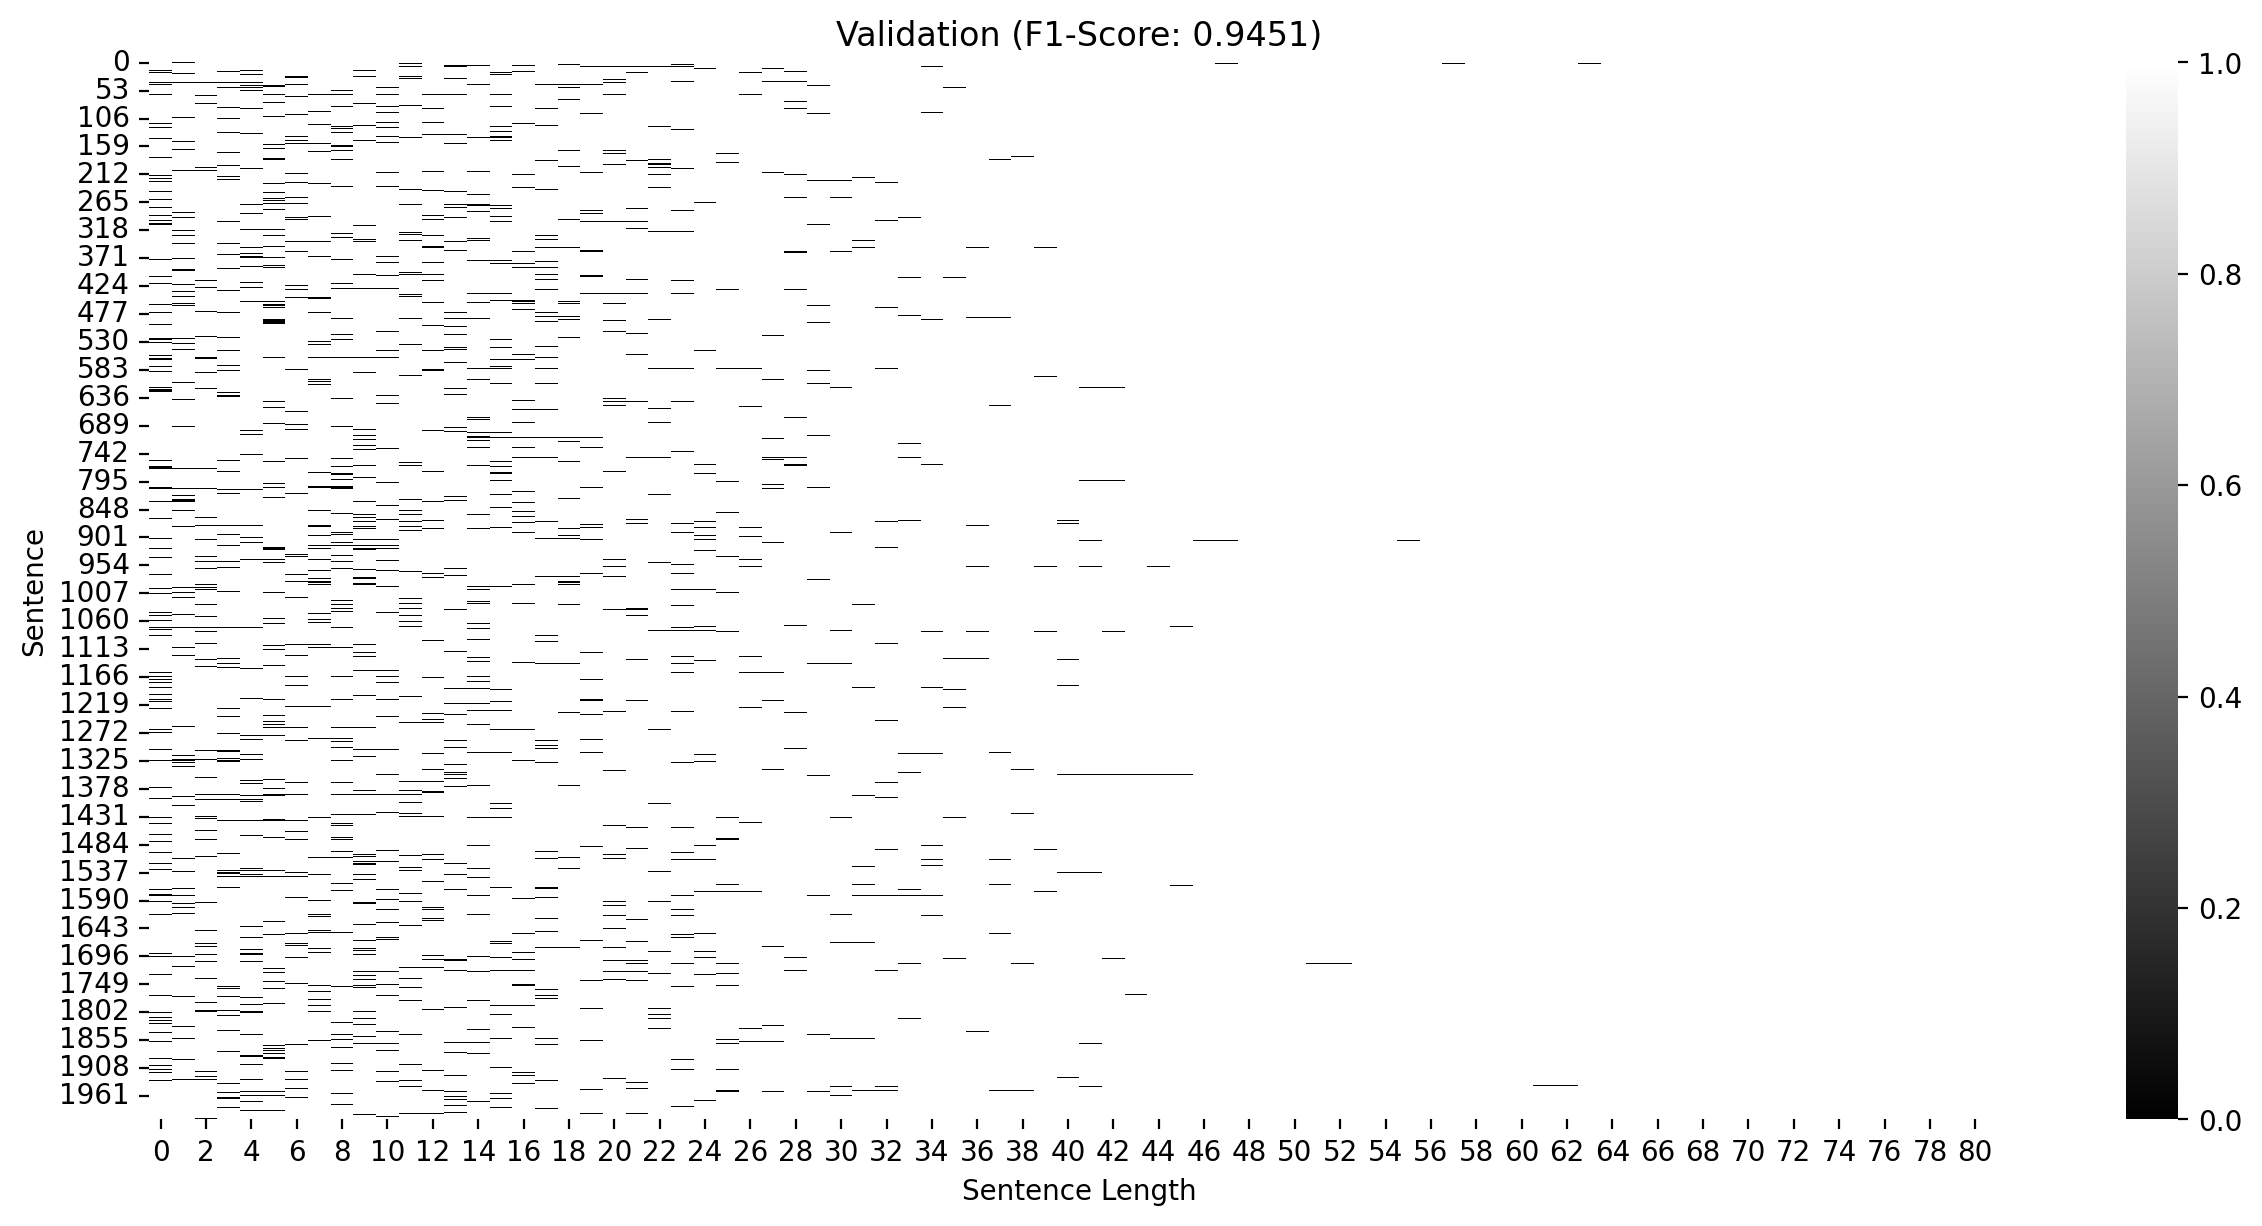

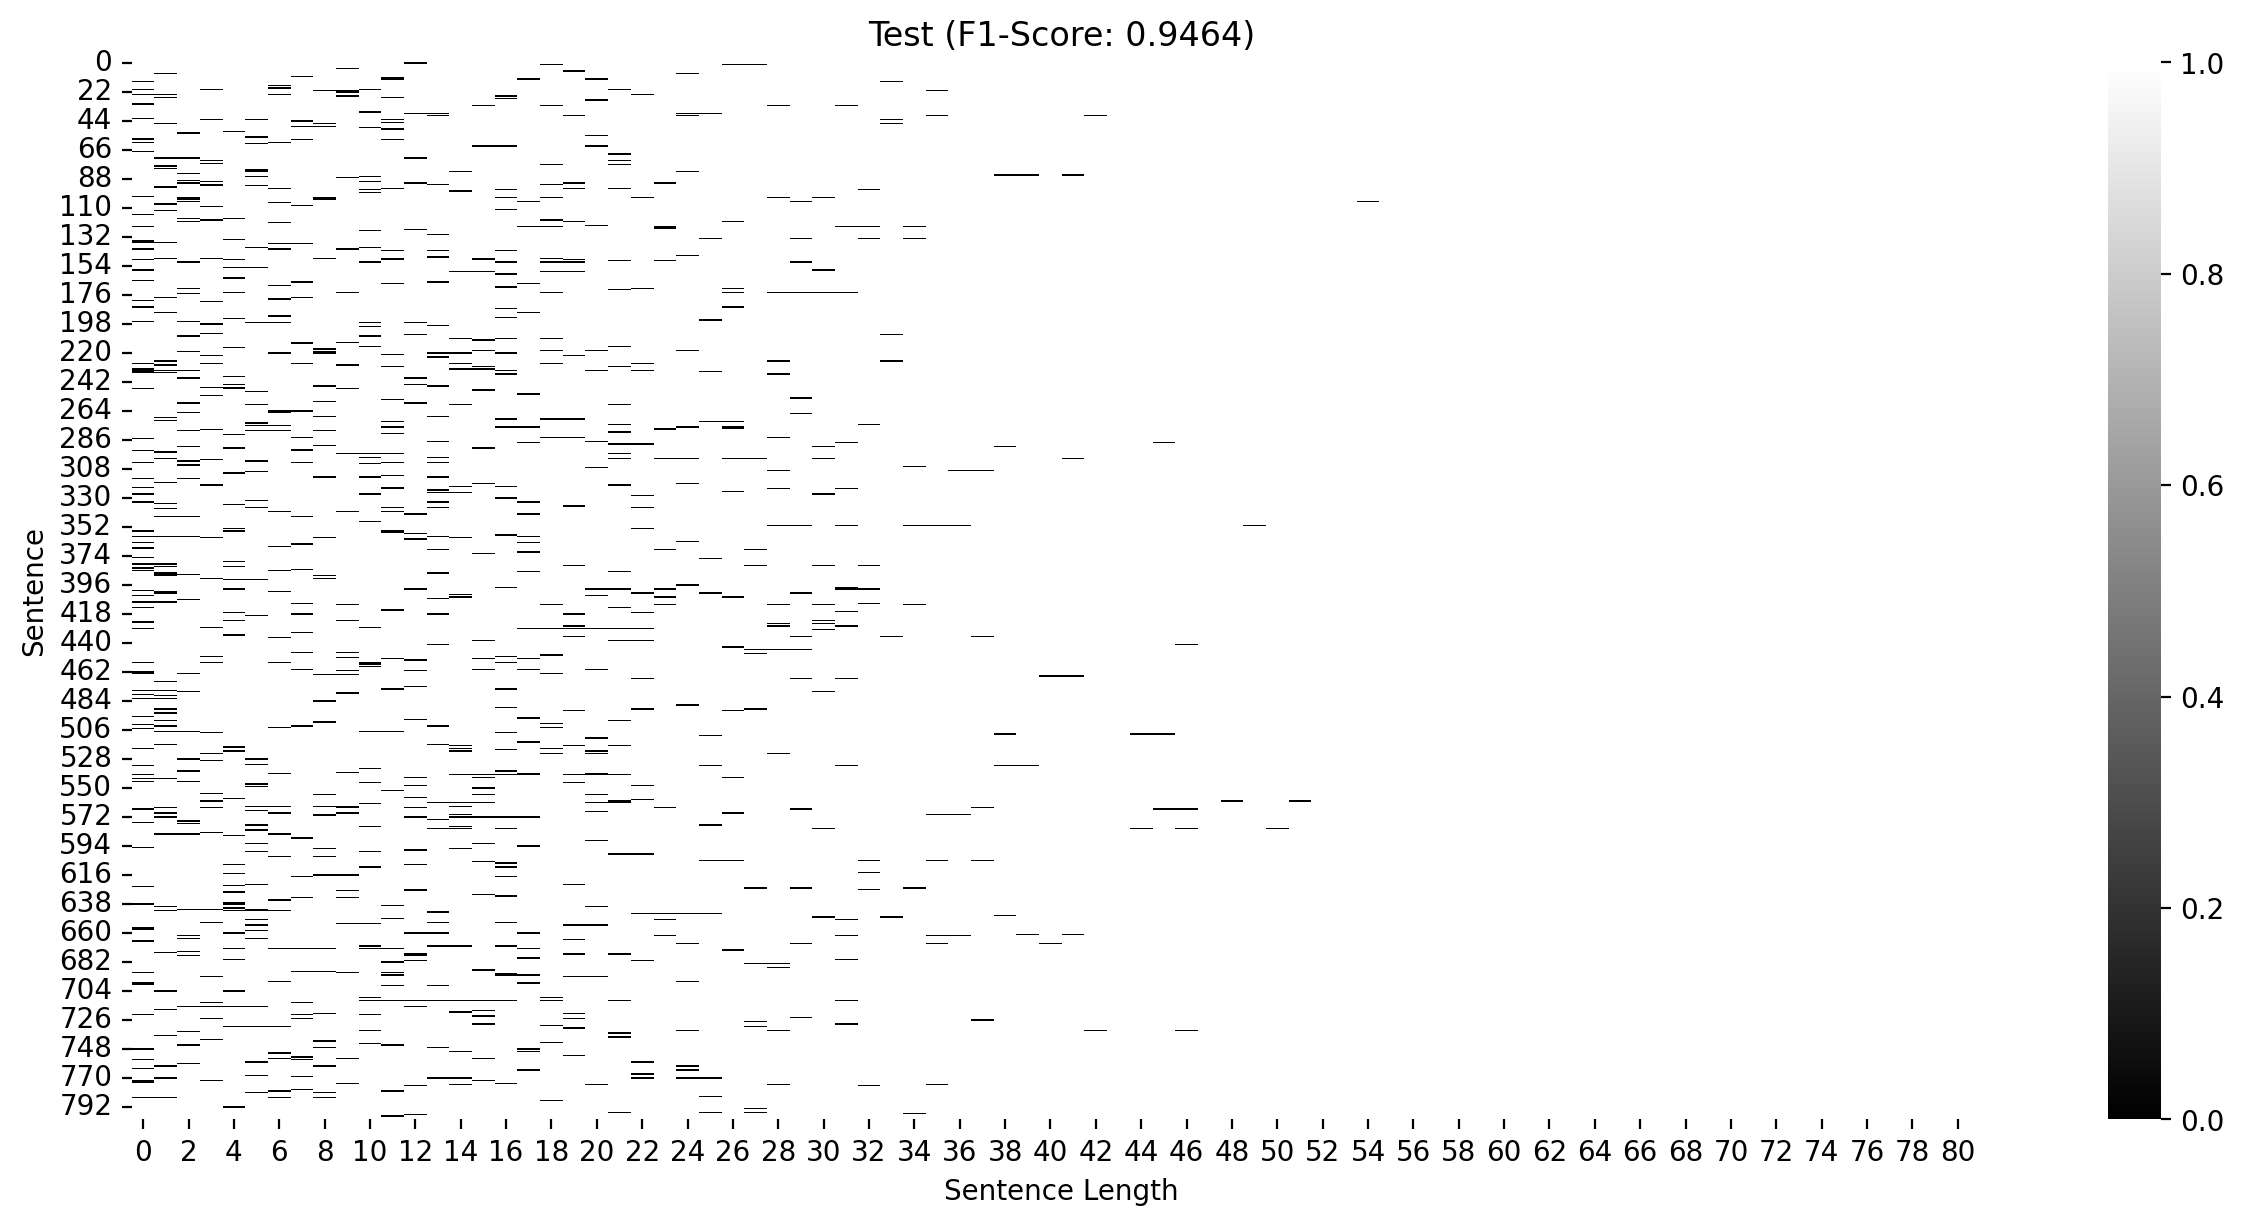

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


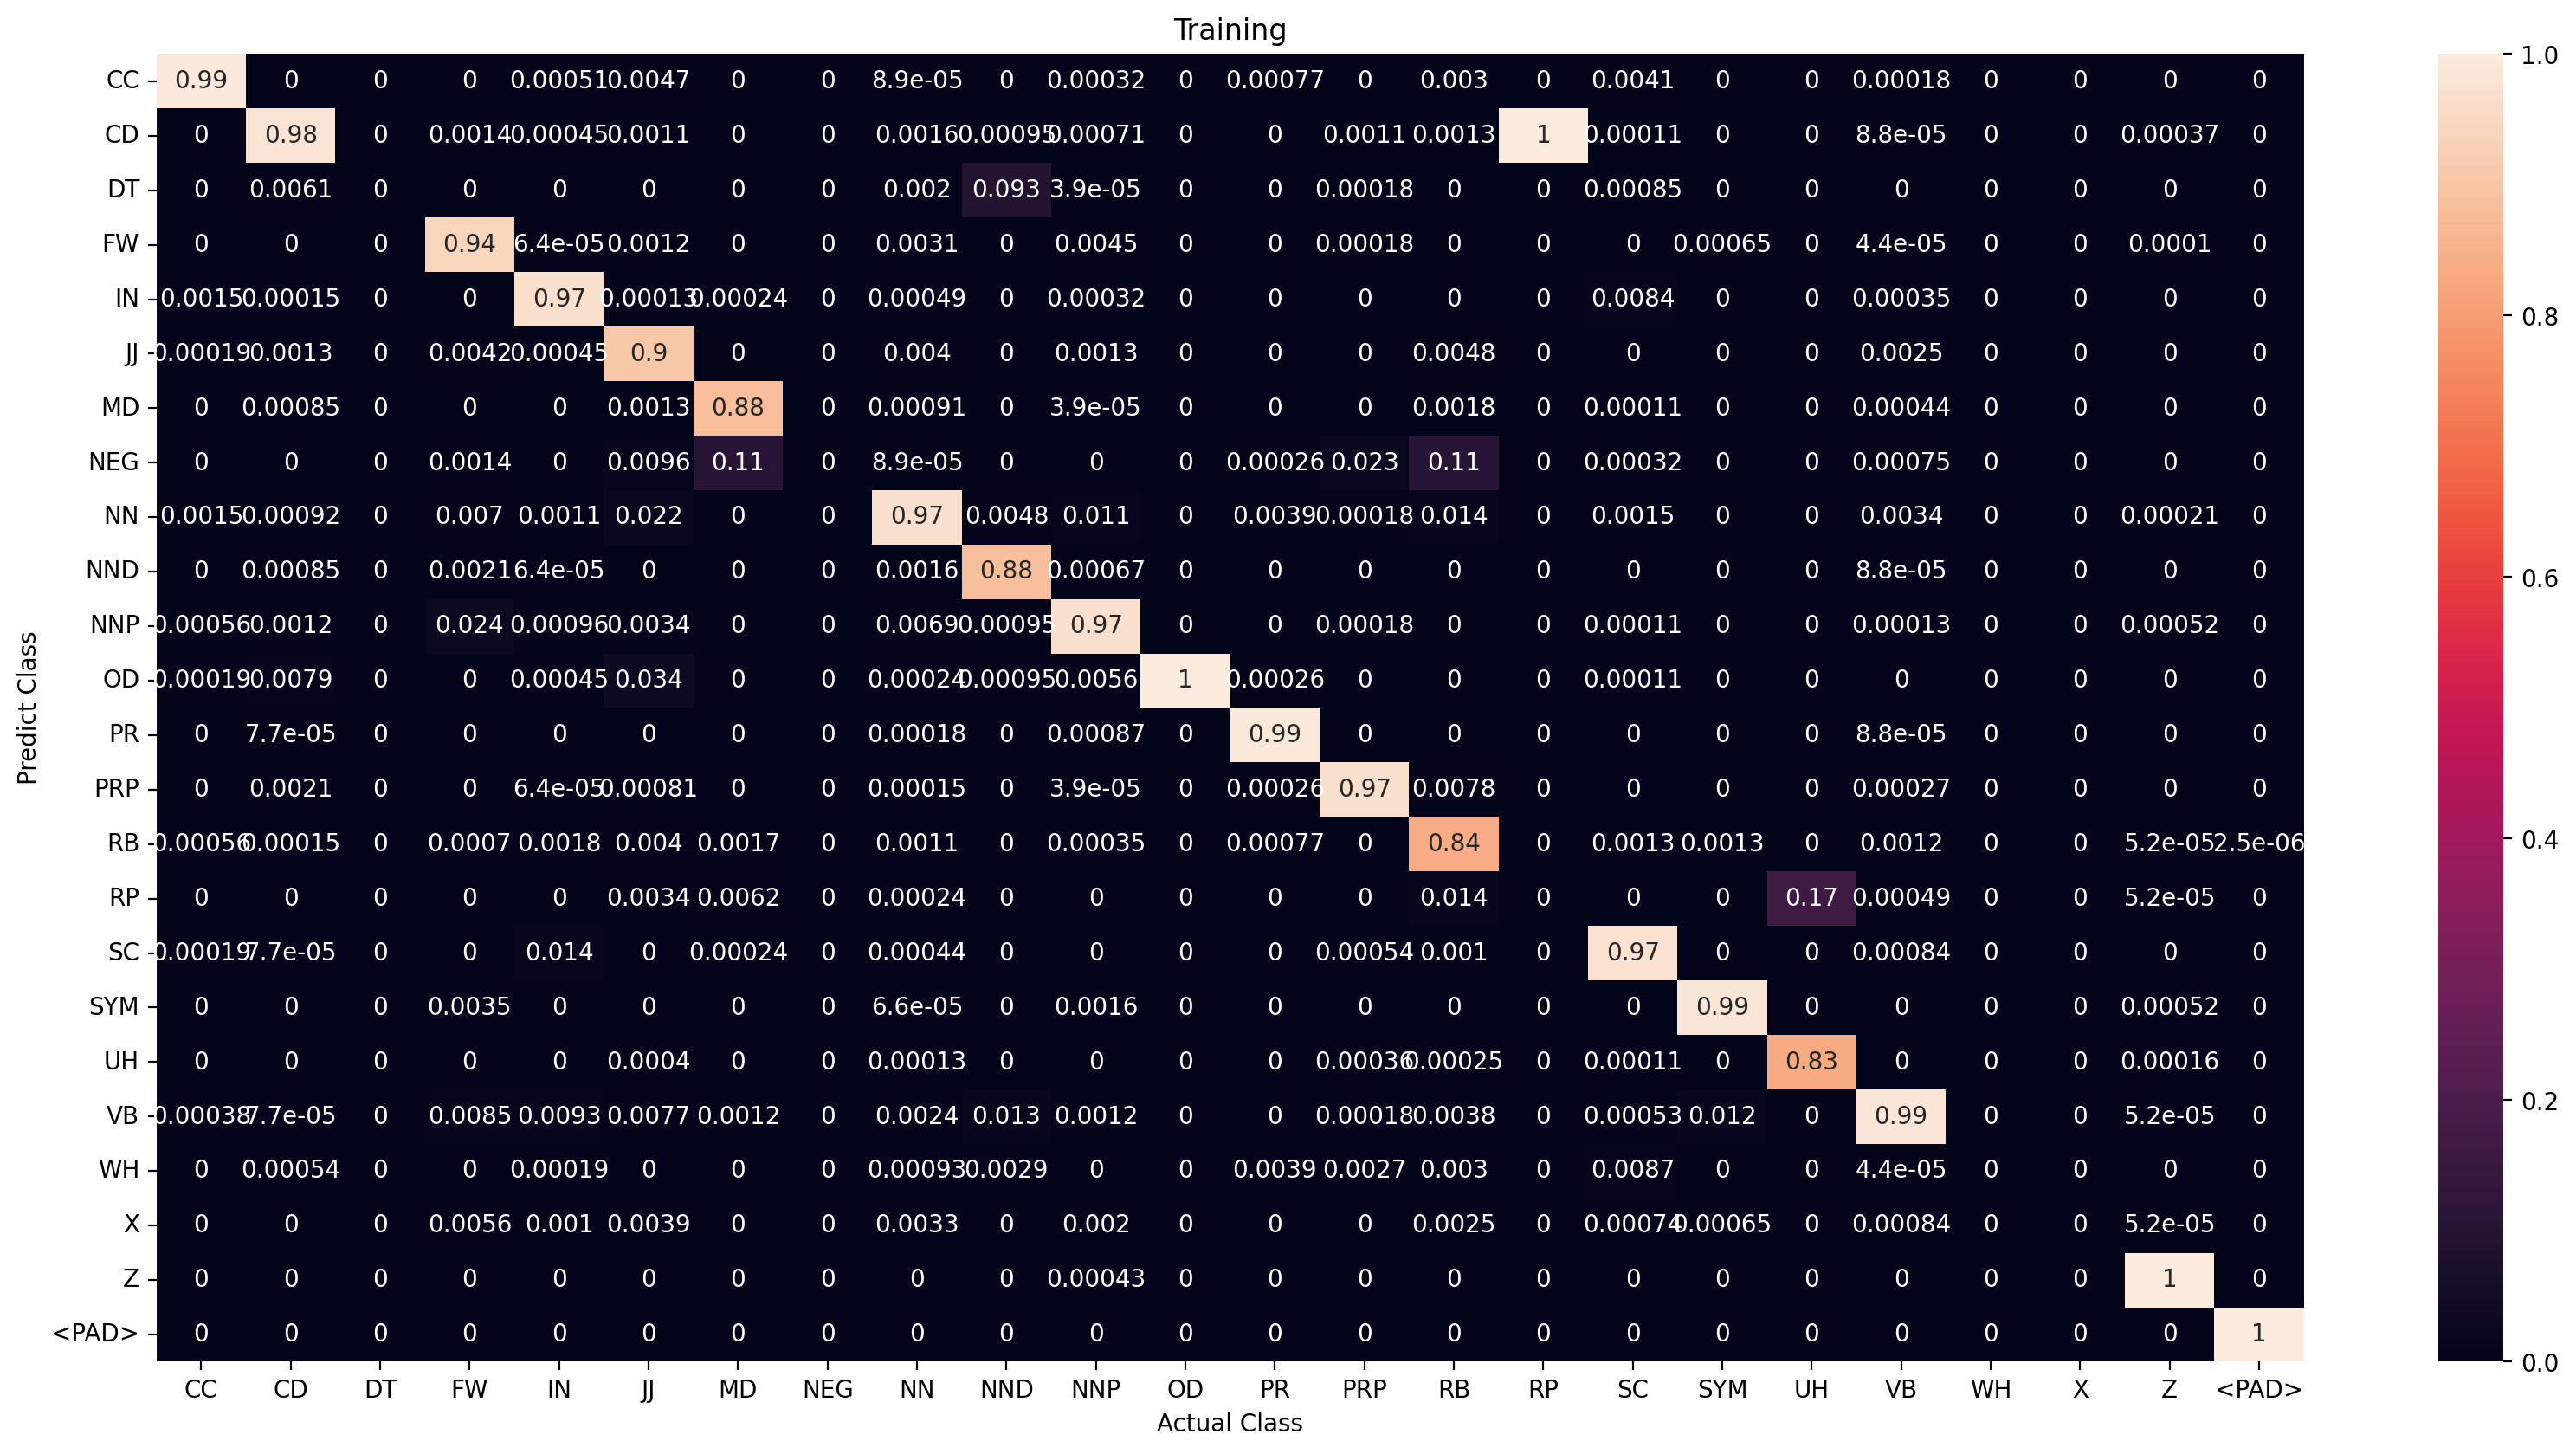

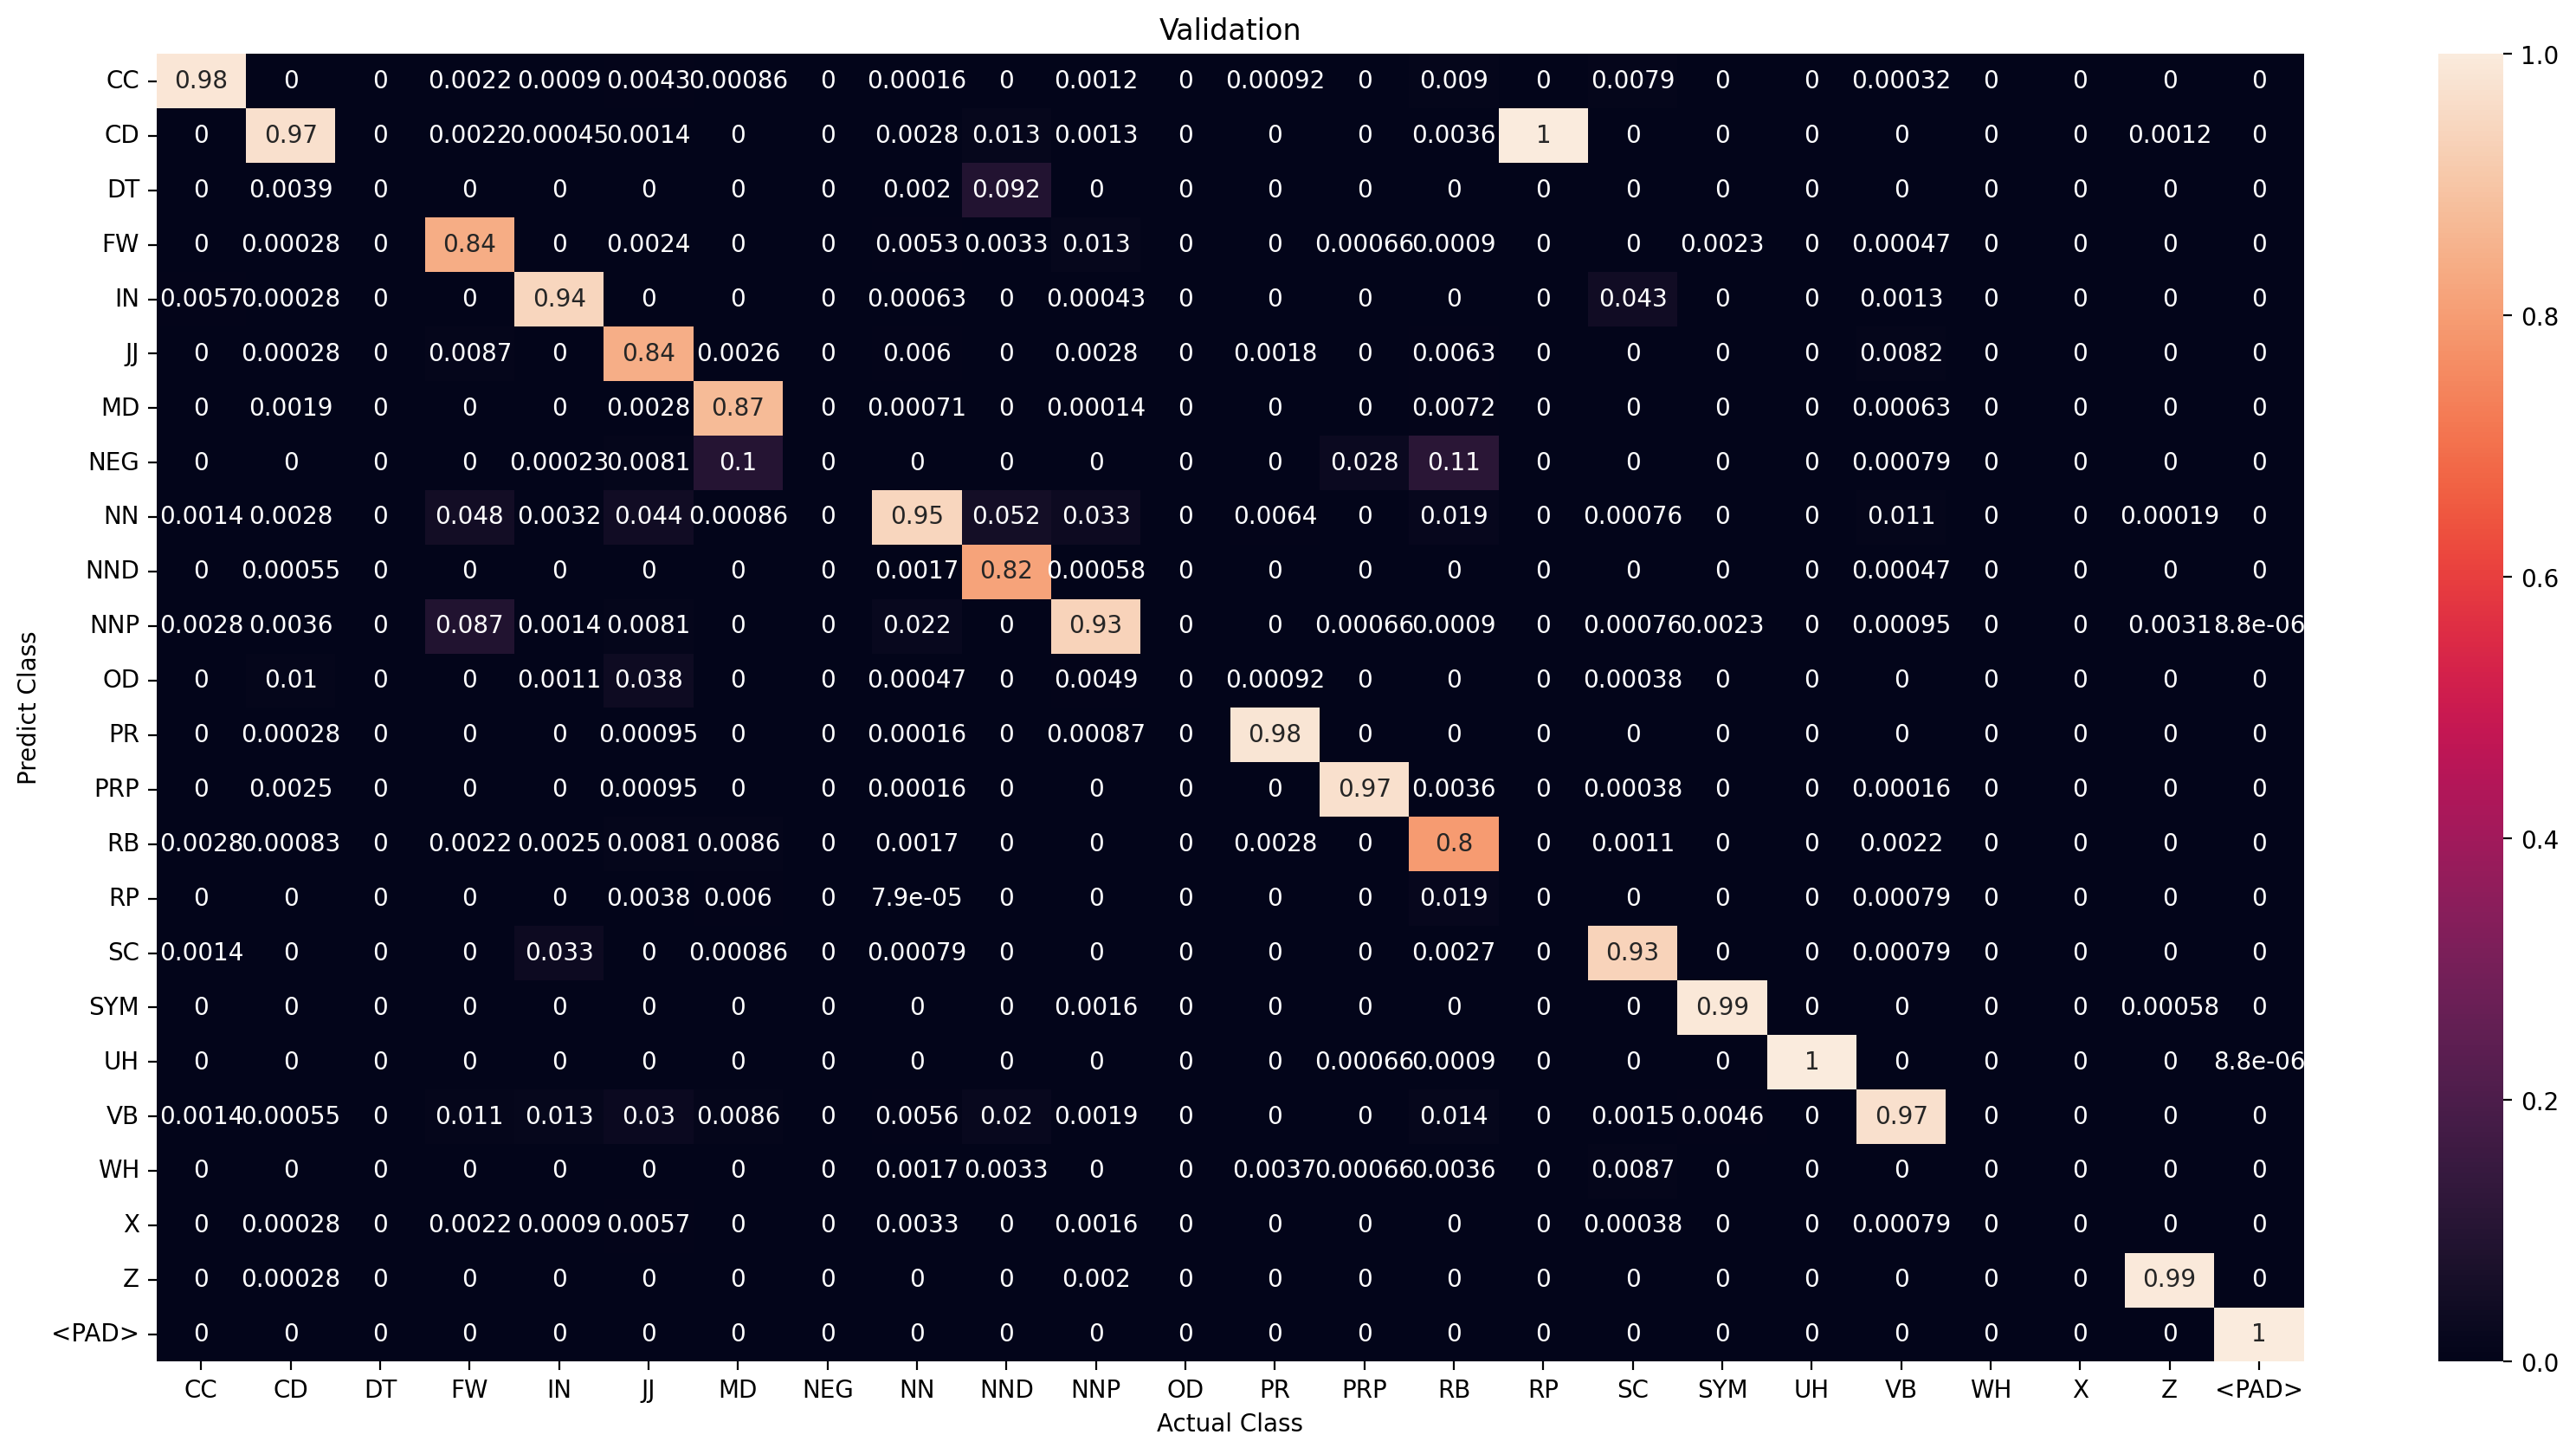

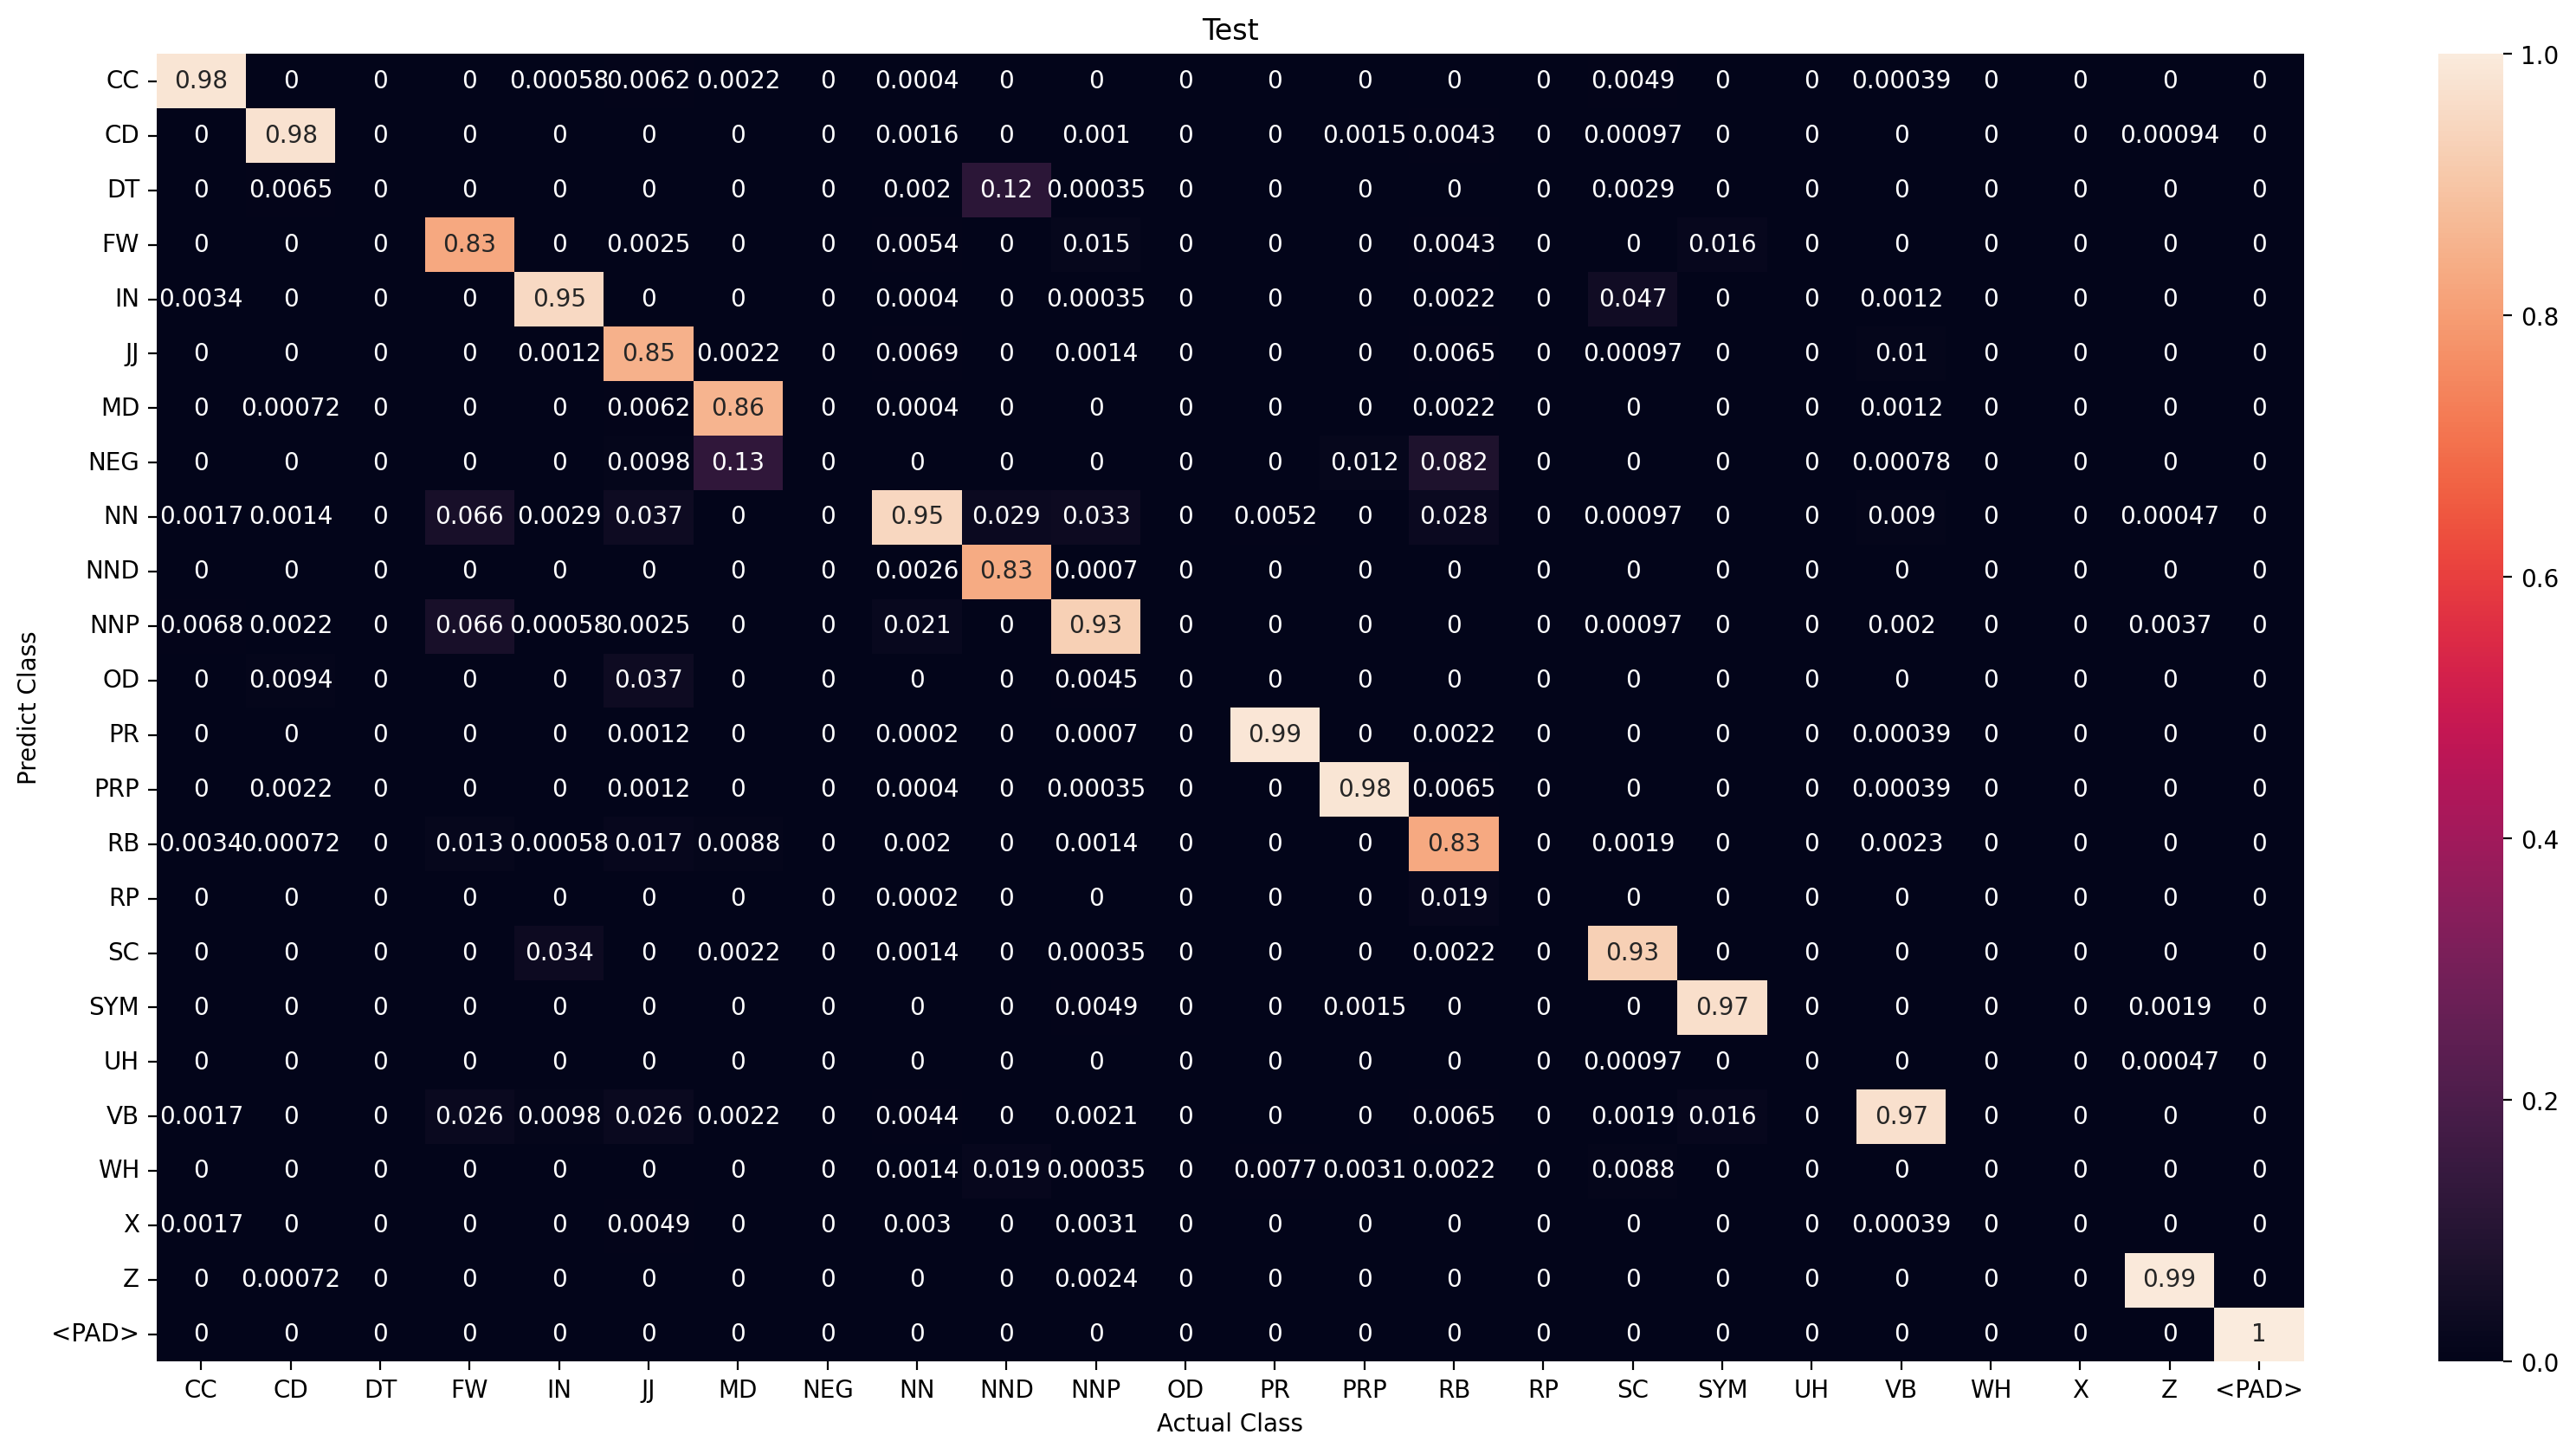

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5284       | CC    : 113      |
| CD    : 12862  | CD    : 12719      | CD    : 143      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1336       | FW    : 269      |
| IN    : 15290  | IN    : 15161      | IN    : 129      |
| JJ    : 7025   | JJ    : 6704       | JJ    : 321      |
| MD    : 3798   | MD    : 3717       | MD    : 81       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43813      | NN    : 659      |
| NND   : 1033   | NND   : 926        | NND   : 107      |
| NNP   : 25007  | NNP   : 24586      | NNP   : 421      |
| OD    : 519    | OD    : 2          | OD    : 517      |
| PR    : 3880   | PR    : 3847       | PR    : 33       |
| PRP   : 5449   | PRP   : 5369       | PRP   : 80       |
| RB    : 3502   | RB    : 3327       | RB    : 175      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11203
Wrong prediction            : 768
Percentage correct oov pred : 93.5844958650071

Validation
Number OOV token            : 3190
Correct prediction          : 2802
Wrong prediction            : 388
Percentage correct oov pred : 87.83699059561128

Test
Number OOV token            : 1401
Correct prediction          : 1244
Wrong prediction            : 157
Percentage correct oov pred : 88.7937187723055



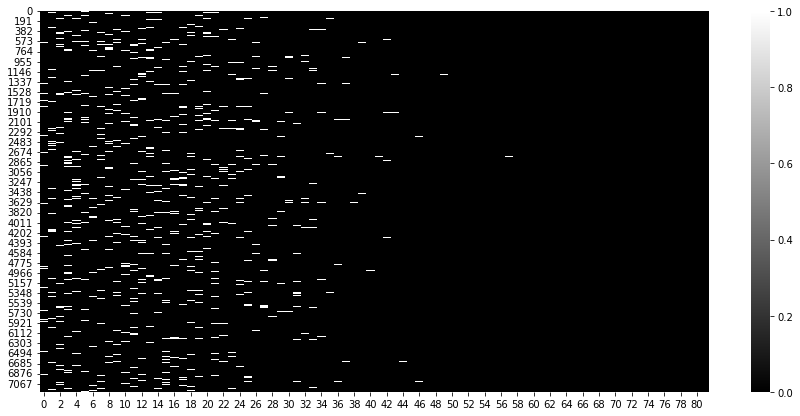

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

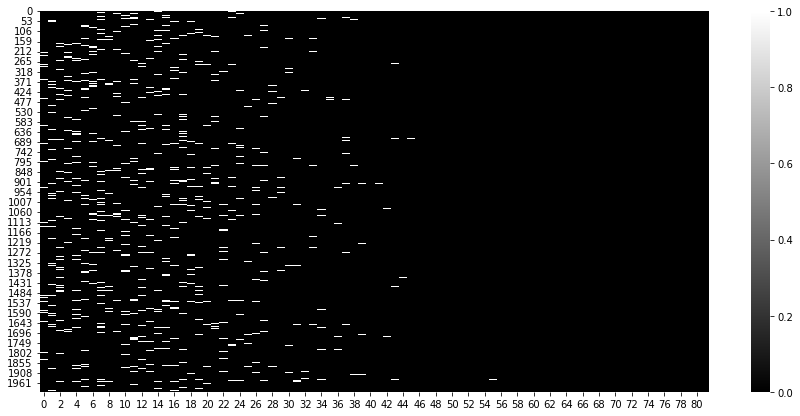

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

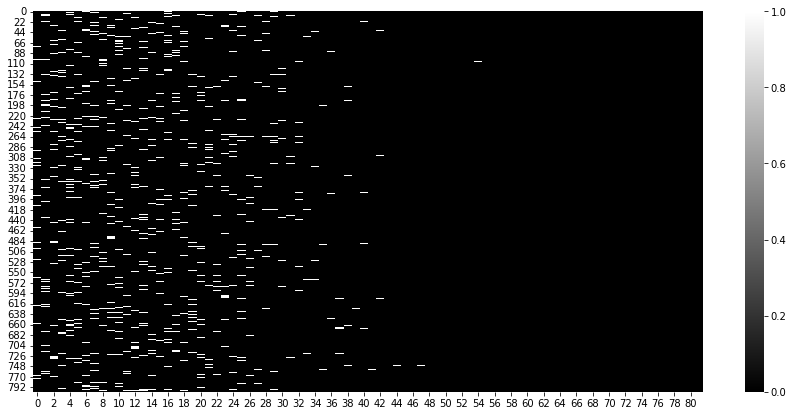

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);